In [ ]:
# !pip3 install pypesq
# !pip3 install pystoi
# !pip3 install pypeaq
# !pip3 install librosa
# !pip3 install scipy
# !pip3 install sklearn
# !pip3 install matplotlib

In [1]:

### import pandas as pd
import os,sys
import librosa
import librosa.display
import struct
import numpy as np
import math
from sklearn.preprocessing import normalize
import tensorflow as tf
import os
import scipy
from scipy import signal
import multiprocessing

import tensorflow as tf 
import random
from sklearn.model_selection import train_test_split 
import numpy as np
from matplotlib import pyplot as plt
import noisereduce as nr
from scipy.signal import butter, lfilter


        
import pydub
from pydub import AudioSegment
from pydub.utils import make_chunks


/usr/local/lib/python3.6/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.6/dist-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import tensorflow as tf


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

1 Physical GPUs, 1 Logical GPU
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5842108033864039173
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10242622207155634704
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6860681768124873081
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5620432896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15299055608390776069
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:09:00.0, compute capability: 6.1"
]
Default GPU Device: /device:GPU:0


In [3]:
# --------------------------------------------------------------------------------------------
import os,sys
import random

import gc
import numpy as np
import struct
import math
import noisereduce as nr
import IPython.display as ipd
import librosa
import scipy
from sklearn.preprocessing import StandardScaler
import time
import datetime
import pandas as pd

from tqdm import tqdm
from scipy import signal
from IPython.display import clear_output
from matplotlib import pyplot as plt
from livelossplot import PlotLossesKeras
# --------------------------------------------------------------------------------------------
import utils
from utils import WavFileHelper
from utils import FeatureExtraction


%matplotlib inline



# Dataset Preparation

In [4]:
urbanSound_noise_dataset = '/docker_ws/Datasets/UrbanSound8K/audio/'
def path_class(filename):
    excerpt = data[data['slice_file_name'] == filename]
    path_name = os.path.join('/docker_ws/Datasets/UrbanSound8K/audio', 'fold'+str(excerpt.fold.values[0]), filename)
    return path_name, excerpt['classID'].values[0]

data = pd.read_csv("/docker_ws/Datasets/UrbanSound8K/metadata/UrbanSound8K.csv")
data.shape

appended = []
for i in range(1,11):
    appended.append(data[data.fold == i]['class'].value_counts())
    
class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

print(data['class'].value_counts(normalize=False))


classDict = {
    9:"street_music",
    8: "siren",
    7: "jackhammer",
    6: "gun_shot",
    5: "engine_idling",
    4: "drilling",
    3: "dog_bark",
    2: "children_playing",
    1: "car_horn",
    0: "air_conditioner"
}

jackhammer          1000
street_music        1000
air_conditioner     1000
drilling            1000
dog_bark            1000
engine_idling       1000
children_playing    1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64


In [5]:
train_labels = []
train_u8k_noise=[]
train_u8k_filepaths = []

for parent, dirs, files in os.walk(urbanSound_noise_dataset):
    if 'fold10' in dirs:
        dirs.remove('fold10')
    for dirname in dirs:
        pass
    for filename in files:
        if filename.endswith('.wav'):
                train_u8k_noise.append(filename)


for wavfile in tqdm(train_u8k_noise):
    filepath, label= path_class(wavfile)
    train_u8k_filepaths.append(filepath)
    train_labels.append([label])


labelledFilenames = zip(train_u8k_filepaths,train_labels)
labelledFilenamesList = list(labelledFilenames) 





100%|██████████| 7875/7875 [00:08<00:00, 979.38it/s] 


In [6]:
print(len(train_u8k_noise))

7875


In [7]:
## random.seed(42, version=2)
np.random.seed(42)
tf.random.set_seed(42)
from sklearn.model_selection import train_test_split
#--------------------------------------------------------------------------------------------
urbanSound_noise_dataset2 = '/docker_ws/Datasets/UrbanSound8K/audio/fold1/'
mymir_voice_dataset	="/docker_ws/Datasets/Mymir/Training/StrippedVoices/"
mozilla_voice_dataset="/docker_ws/Datasets/Mozilla/clips/train/"
mir_noise_dataset  = "/docker_ws/Datasets/Mymir/Noises/"
rnn_noise_dataset = "/docker_ws/Datasets/rnnoise_contributions/"
test_voice_dataset	="/docker_ws/Datasets/Mymir/Testing/TestFiles/"
libri_voice_dataset = "/docker_ws/Datasets/OpenSLR/LibriSpeech/dev-clean/"


windowLength = 512 #for a 25 ms window 
overlap      = round(0.25 * windowLength) # overlap of 75%
# overlap = 1
ffTLength    = windowLength
inputFs      = 16e3
fs           = 16e3
numFeatures  = ffTLength//2 + 1
numSegments  = 8
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",ffTLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)


#--------------------------------------------------------------------------------------------


for mcv_root,_,mozilla_voice in os.walk(mozilla_voice_dataset):
    mozilla_voice = [x for x in mozilla_voice if x.endswith('.wav')]
    mozilla_voice = sorted(mozilla_voice)

for mirV_root,_,mymir_voice in os.walk(mymir_voice_dataset):
    mymir_voice = [x for x in mymir_voice if x.endswith('.wav') and not'_nr' in x]
    mymir_voice = sorted(mymir_voice) 

for rnn_noise_root,_,rnn_noise in os.walk(rnn_noise_dataset):
    rnn_noise = [x for x in rnn_noise if x.endswith('.raw')]
    rnn_noise = sorted(rnn_noise) 
    
for libri_voice_root,_,libri_voice in os.walk(libri_voice_dataset):
    libri_voice = [x for x in libri_voice if x.endswith('.flac')]
    libri_voice = sorted(libri_voice) 
#-------------------------------------------------
for u8k_root,_,u8k_noise in os.walk(urbanSound_noise_dataset2):
    [x for x in u8k_noise if x.endswith('.wav')]
    u8k_noise = sorted(u8k_noise)

for mirN_root,_,mymir_noise in os.walk(mir_noise_dataset):
    [x for x in mymir_noise if x.endswith('.wav')]
    mymir_noise = sorted(mymir_noise)


#--------------------------------------------------
for mirT_root,_,mixed_test_voice in os.walk(test_voice_dataset):
    mixed_test_voice = sorted(mixed_test_voice)
#---------------------------------------------------

# mirVdataset = []   
# for a in mymir_voice:
#     mirVdataset.append(([mirV_root],[a]))
# mirNdataset = []  
# for b in mymir_noise:
#     mirNdataset.append(([mirN_root],[b]))
# # u8kdataset = []
# # for c in u8k_noise:
# #     u8kdataset.append(([u8k_noise],[c]))
# mcvDataset = []  
# for d in mcv_root:
#     mcvDataset.append(([mcv_root],[d]))

#---------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------

windowLength: 512
overlap: 128
ffTLength: 512
inputFs: 16000.0
fs: 16000.0
numFeatures: 257
numSegments: 8


In [8]:
print((mymir_voice[10]))

Ani_2_04_voice.wav


In [9]:
from sklearn.model_selection import train_test_split

train_mir_voice =[]
validation_mir_voice = []

train_mir_voice,validation_mir_voice = train_test_split(mymir_voice, test_size=0.2, random_state=42)

#---------------------------------------------------------------------------------------------


train_mir_voice_paths = []
validation_mir_voice_paths =  []
test_mir_voice_paths =  []

validation_mir_voice,test_mir_voice = train_test_split(validation_mir_voice, test_size=0.5, random_state=42)



for i in train_mir_voice:
    train_mir_voice_paths.append(os.path.join(mirV_root,i))

for i in validation_mir_voice:
    validation_mir_voice_paths.append(os.path.join(mirV_root,i))
    
for i in test_mir_voice:
    test_mir_voice_paths.append(os.path.join(mirV_root,i))    
#---------------------------------------------------------------------------------------------

In [10]:
WavFileHelper.play_audio(random.choice(train_mir_voice_paths),16000,0)
print(random.choice(train_mir_voice_paths))

/docker_ws/Datasets/Mymir/Training/StrippedVoices/davidson_2_04_voice.wav


In [11]:
mzcv_s = random.sample(mozilla_voice,10000)

# mzcv_s = mozilla_voice


mozilla_train_paths = []
for i in mzcv_s:
    fullpath = os.path.join(mcv_root,i)
    mozilla_train_paths.append(fullpath)
    
train_mozilla_voice,validation_mozilla_voice_temp = train_test_split(mozilla_train_paths, test_size=0.3, random_state=42)
test_mozilla_voice,validation_mozilla_voice = train_test_split(validation_mozilla_voice_temp, test_size=0.5, random_state=42)

print(len(train_mozilla_voice))
print(len(validation_mozilla_voice))
print(len(test_mozilla_voice))

# print(len(mzcv_s))

7000
1500
1500


In [12]:
print(random.choice(mozilla_train_paths))
WavFileHelper.play_audio(random.choice(mozilla_train_paths),16000,0)

/docker_ws/Datasets/Mozilla/clips/train/common_voice_en_18844486.wav


In [13]:
# #Convert 10,000 random samples from the MCV dataset from .mp3 to .wav

# import multiprocessing
# import time
# import soundfile as sf

# resultlist = []  
# def nameToStft(filePath):
#     fullpath = os.path.join(mcv_root,filePath)
#     u = 'c'
#     if os.path.exists(str(mcv_root+os.path.splitext(filePath)[0]+'.wav')):
#         pass
#     else:
#         x, sr = librosa.load(fullpath, sr=16000,mono=True,dtype=np.float32)
#         x = nr.reduce_noise(audio_clip=x, noise_clip=x[0:8000], verbose=False)
#         u = librosa.util.valid_audio(x,mono=True)
#         sf.write(str(mcv_root+os.path.splitext(filePath)[0]+'.wav'), x, 16000, 'PCM_16')
#         assert u == True
    
#     return u
 
# def parallel_runs(numProcess):
#     with multiprocessing.Pool(processes=numProcess) as pool:
#         for i in tqdm(pool.imap(nameToStft, mzcv_s[0:len(mzcv_s)]), total=len(mzcv_s)):
#             resultlist.append(i)
#         pool.close()
#         pool.join()

    
# parallel_runs(numProcess=8)


In [14]:
# #  x = sf.SoundFile(os.path.join(mcv_root,random.choice(train_mozilla_voice)))
    
    
# print(str(mcv_root+os.path.splitext(mozilla_voice[1])[0]+'.wav'))

In [15]:
# # check that all of the noise files contain valid audio

# for i in tqdm(mozilla_voice):
#     fullpath = os.path.join(mcv_root,i)

#     assert u == True

In [16]:
# file = os.path.join(mcv_root,random.choice(mozilla_voice))
# audio,sr = WavFileHelper.read_audio(file,16000)
# audio = np.asarray(audio,dtype=np.float32)
# import noisereduce as nr
# test = nr.reduce_noise(audio_clip=audio, noise_clip=audio[0:8000], verbose=False)
# WavFileHelper.play_audio(test,16000,0)


In [17]:
# Create array for train / test filenames (Running this cell more than once splits the cell again)
# train_u8k_noise = []
# validation_u8k_noise = []

train_u8k_noise,validation_u8k_noise = train_test_split(train_u8k_noise, test_size=0.15, random_state=42)

# Create arrays for full paths to the training/validation files
train_u8k_noise_paths = []
validation_u8k_noise_paths = []

for i in tqdm(train_u8k_noise):
    train_u8k_noise_paths.append(path_class(i))

for i in tqdm(validation_u8k_noise):
    validation_u8k_noise_paths.append(path_class(i))
    
#---------------------------------------------------------------------------------------------
# Create arrays containing: test labels, filepaths, labels+filepaths
test_u8k_labels = []
test_u8k_filepaths = []
test_u8k_noise=[]  

for parent, dirs, files in tqdm(os.walk(urbanSound_noise_dataset)):
    for dirname in dirs:
        pass
    for filename in files:
        if filename.endswith('.wav') and filename not in train_u8k_noise and filename not in validation_u8k_noise:
                test_u8k_noise.append(path_class(filename))

#---------------------------------------------------------------------------------------------
# Create an array of combined filepaths + labels

for wavfile in tqdm(test_u8k_noise):
    filepath, label= wavfile
    test_u8k_filepaths.append(filepath)
    test_u8k_labels.append([label])


test_u8k_labelledFilenames = zip(test_u8k_filepaths,test_u8k_labels)
test_u8k_labelledFilenamesList = list(test_u8k_labelledFilenames) 

100%|██████████| 1182/1182 [00:01<00:00, 947.98it/s]
11it [00:01,  7.64it/s]
100%|██████████| 837/837 [00:00<00:00, 1437016.97it/s]


In [18]:
numTrainVoices = len(train_mir_voice_paths)
numValidationVoices = len(validation_mir_voice_paths)
numTestVoices = len(test_mir_voice_paths)

print('# of clean training files: ' + str(numTrainVoices))
print('# of clean validation files: ' + str(numValidationVoices))
print('# of clean test files: ' + str(numTestVoices))

# of clean training files: 800
# of clean validation files: 100
# of clean test files: 100


In [19]:
numTrainNoises = len(train_u8k_noise_paths)
numValidationNoises = len(validation_u8k_noise_paths)
numTestNoises = len(test_u8k_noise)

print('# of noise training files: ' + str(numTrainNoises))
print('# of noise validation files: ' + str(numValidationNoises))
print('# of noise test files: ' + str(numTestNoises))


print('----------------Train---------------')   
trainClasses = []
for i in train_u8k_noise_paths:
    j = i[0].split('/')
    j = j[6]
#     print(j)
    j = path_class(j)
    trainClasses.append(i[1])
for i in range(10):    
    print(str(classDict[i])+ ':'+'\n' + str(trainClasses.count(i)))
    
print('----------------Validation---------------')    
  
valClasses = []
for i in validation_u8k_noise_paths:
    j = i[0].split('/')
    j = j[6]
#     print(j)
    j = path_class(j)
    valClasses.append(i[1])
for i in range(10):    
    print(str(classDict[i])+ ':'+'\n' + str(valClasses.count(i)))
    
    
print('----------------Test---------------')    
  
testClasses = []
for i in test_u8k_noise:
    j = i[0].split('/')
    j = j[6]
#     print(j)
    j = path_class(j)
    testClasses.append(i[1])
for i in range(10):    
    print(str(classDict[i])+ ':'+'\n' + str(testClasses.count(i)))

# of noise training files: 6693
# of noise validation files: 1182
# of noise test files: 837
----------------Train---------------
air_conditioner:
766
car_horn:
341
children_playing:
762
dog_bark:
764
drilling:
768
engine_idling:
755
gun_shot:
285
jackhammer:
767
siren:
721
street_music:
764
----------------Validation---------------
air_conditioner:
134
car_horn:
55
children_playing:
138
dog_bark:
136
drilling:
132
engine_idling:
132
gun_shot:
57
jackhammer:
137
siren:
125
street_music:
136
----------------Test---------------
air_conditioner:
100
car_horn:
33
children_playing:
100
dog_bark:
100
drilling:
100
engine_idling:
93
gun_shot:
32
jackhammer:
96
siren:
83
street_music:
100


In [20]:
# print(theClasses)

In [21]:
numTrainVoices = len(train_mozilla_voice)
numValidationVoices = len(validation_mozilla_voice)
numTestNoisesVoices = len(test_mozilla_voice)

print('# of clean training files: ' + str(numTrainVoices))
print('# of clean validation files: ' + str(numValidationVoices))
print('# of clean test files: ' + str(numTestNoisesVoices))

# of clean training files: 7000
# of clean validation files: 1500
# of clean test files: 1500


In [22]:
train_u8k_noise_paths[1]

('/docker_ws/Datasets/UrbanSound8K/audio/fold8/169043-2-0-28.wav', 2)

In [23]:
#validation_mozilla_voice
#train_mozilla_voice

In [24]:
# # check that all of the noise files contain valid audio

# for i in tqdm(u8k_filepaths):
#     x,sr = WavFileHelper.read_audio(i,16000)
#     u = librosa.util.valid_audio(x,mono=True)
#     assert u == True

In [25]:
# #Check that all of the voice files contain valid audio

# for i in tqdm(train_mir_voice_paths):
#     x,sr = WavFileHelper.read_audio(i,16000)
#     u = librosa.util.valid_audio(x,mono=True)
#     print(u)
#     assert u == True 

In [26]:
# print(os.path.join(u8k_root,test_u8k_noise[1]))

# Model Training

In [27]:
class KerasSequenceGenerator2(tf.keras.utils.Sequence):
    
    import warnings
    warnings.filterwarnings('ignore')
    'Generates data for Keras'
    def __init__(self, voiceArray,noiseArray,batch_size,maxNoiseAdjust=0,shuffle=False):
        'Initialization'
        self.voiceArray = voiceArray
        self.noiseArray = noiseArray
        self.batch_size = batch_size
        self.maxNoiseAdjust = maxNoiseAdjust 
        self.numEpoch = 0
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int((len(self.voiceArray) / self.batch_size))


    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        voiceArray_temp = [self.voiceArray[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(voiceArray_temp)
        
        return X,y

    def on_epoch_end(self):            
        self.numEpoch+=1   
        self.indexes = np.arange(len(self.voiceArray))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        gc.collect()
    def __data_generation(self,voiceArray_temp):   

        xdata = []
        ydata = []
        fs = 16000
        
        def read_audio(filepath, sample_rate=16000, normalize=False):
            audio, sr = librosa.load(filepath, sr=16000,mono=True,dtype=np.float32)

            if normalize:
                        audio = librosa.util.normalize(audio,fill=False)
            
            return audio,sr 
    
    
        def add_noise_to_clean_audio(clean_audio, noise_signal):
            import pynormalize

#             clean_audio = librosa.util.normalize(clean_audio,fill=False)
            if len(clean_audio) > len(noise_signal):
                while len(clean_audio) >= len(noise_signal):
                    noise_signal = np.append(noise_signal, noise_signal)
                noise_signal = noise_signal[0:len(clean_audio)]

            if len(noise_signal) > len(clean_audio):
                while len(noise_signal) >= len(clean_audio):
                    clean_audio = np.append(clean_audio, clean_audio)
                clean_audio = clean_audio[0:len(noise_signal)]

#             clean_audio = librosa.util.normalize(clean_audio,fill=False)
#             noise_signal = librosa.util.normalize(noise_signal,fill=False)
#             noise_signal = noise_signal - random.randint(0,0.5)
            x = random.uniform(0, self.maxNoiseAdjust)
            noise_signal = noise_signal - x
            speech_power = np.sum(clean_audio ** 2)
            noise_power = np.sum(noise_signal ** 2)


            noisyAudio = (clean_audio + np.sqrt(speech_power / noise_power) * noise_signal)
#             noisyAudio = librosa.util.normalize(noisyAudio,fill=False)
            noisyAudio = np.asarray(noisyAudio,dtype=np.float32)

            return clean_audio,noisyAudio,noise_signal
        
        def get_stft_spectrogram(audio):
            
            stft = librosa.stft(audio, n_fft=512, win_length=512, hop_length=128,
                            window=scipy.signal.hamming(512, sym=False), center=True)
            
            return stft
        
        noiseList = self.noiseArray
        for idx,i in enumerate(voiceArray_temp):
            
            cleanVoicePath = i
            randomNoisePath = os.path.join(random.choice(noiseList)[0])

            cleanAudio,sr = read_audio(cleanVoicePath)
            noiseAudio,sr = read_audio(randomNoisePath)

            cleanAudio,mixedAudio,noise = add_noise_to_clean_audio(cleanAudio,noiseAudio)
            cleanAudio = librosa.util.normalize(cleanAudio,fill=False)
            noiseAudio = librosa.util.normalize(noiseAudio,fill=False)
            
            
            clean_stft_features = get_stft_spectrogram(cleanAudio)   
            clean_stft_mag = np.abs(clean_stft_features)
            clean_stft_mean = np.mean(clean_stft_features)
#             clean_stft_std = np.std(clean_stft_features)
#             clean_stft_mean = np.mean(clean_stft_features)
            clean_stft_std = np.std(clean_stft_features)
            clean_stft =  (((clean_stft_mag - clean_stft_mean) / clean_stft_std))        
            clean_stft = np.vstack(clean_stft.T)
            clean_stft = clean_stft.reshape(1,np.size(clean_stft,0),np.size(clean_stft,1))
            

            mixed_stft_features = get_stft_spectrogram(mixedAudio)
            mixed_stft_mag = np.abs(mixed_stft_features)
            mixed_stft_mean = np.mean(mixed_stft_features)
            mixed_stft_std = np.std(mixed_stft_features)
            mixed_stft =  (((mixed_stft_mag - mixed_stft_mean) / mixed_stft_std))
            mixed_stft = np.vstack(mixed_stft.T)
            mixed_stft = mixed_stft.reshape(1,np.size(mixed_stft,0),np.size(mixed_stft,1)) 

            
            xdata.append(np.asarray(mixed_stft))
            ydata.append(np.asarray(clean_stft))
#         print(np.max(cleanAudio))
#         print(np.max(mixedAudio))
        return (xdata),(ydata)
            
            
            

In [28]:
train_voiceFiles = train_mozilla_voice
train_noiseFiles = train_u8k_noise_paths

validation_voiceFiles = validation_mozilla_voice
validation_noiseFiles = validation_u8k_noise_paths

trainDataGen = KerasSequenceGenerator2(voiceArray=train_voiceFiles,
                                       noiseArray=train_noiseFiles,
                                       batch_size=1)   

valDataGen =  KerasSequenceGenerator2(voiceArray=validation_mozilla_voice,
                                      noiseArray=validation_noiseFiles,
                                      batch_size=1)
gc.collect()

0

In [29]:
%load_ext tensorboard

In [30]:
# import tensorflow.keras.backend as K
from pypesq import pesq
import pesq as pesq2
from pystoi.stoi import stoi

def STOI_Score(y_true,y_pred):
    z = ((tf.py_function(func=STOI_train, inp=[y_pred, y_true], Tout=tf.float32)))
    return z
def PESQ_Score(y_true,y_pred):
    z = ((tf.py_function(func=PESQ_train, inp=[y_pred, y_true], Tout=tf.float32)))
    return z

def STOI_train(x,y):
    x = np.squeeze(x, axis=0)
    x = x.T 
    y = np.squeeze(y, axis=0)
    y = y.T
    
    
    x = librosa.istft(x, win_length=512,hop_length=128,window=scipy.signal.hanning(512, sym=False), center=True)
    y = librosa.istft(y, win_length=512,hop_length=128,window=scipy.signal.hanning(512, sym=False), center=True)
    
    if len(x) > len(y):
        x = x[0:len(y)]
    if len(y) > len(x):
        y = y[0:len(x)]
    else:
        pass
    
    return stoi(x, y, 16000, extended=False)

def PESQ_train(y,x):
    x = np.squeeze(x, axis=0)
    x = x.T 
    y = np.squeeze(y, axis=0)
    y = y.T
        
    x = librosa.istft(x, win_length=512,hop_length=128,window=scipy.signal.hanning(512, sym=False), center=True)
    y = librosa.istft(y, win_length=512,hop_length=128,window=scipy.signal.hanning(512, sym=False), center=True)
    
    if len(x) > len(y):
        x = x[0:len(y)]
    if len(y) > len(x):
        y = y[0:len(x)]
    else:
        pass
    
    return pesq(x, y, 16000)

129
257
Model: "Test_Build"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 257)]  0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 258)    66564       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 258)    401448      time_distributed[0][0]           
__________________________________________________________________________________________________
add (Add)                       (None, None, 258)    0           time_distributed[0][0]           
                                                                 bidirectional[0]

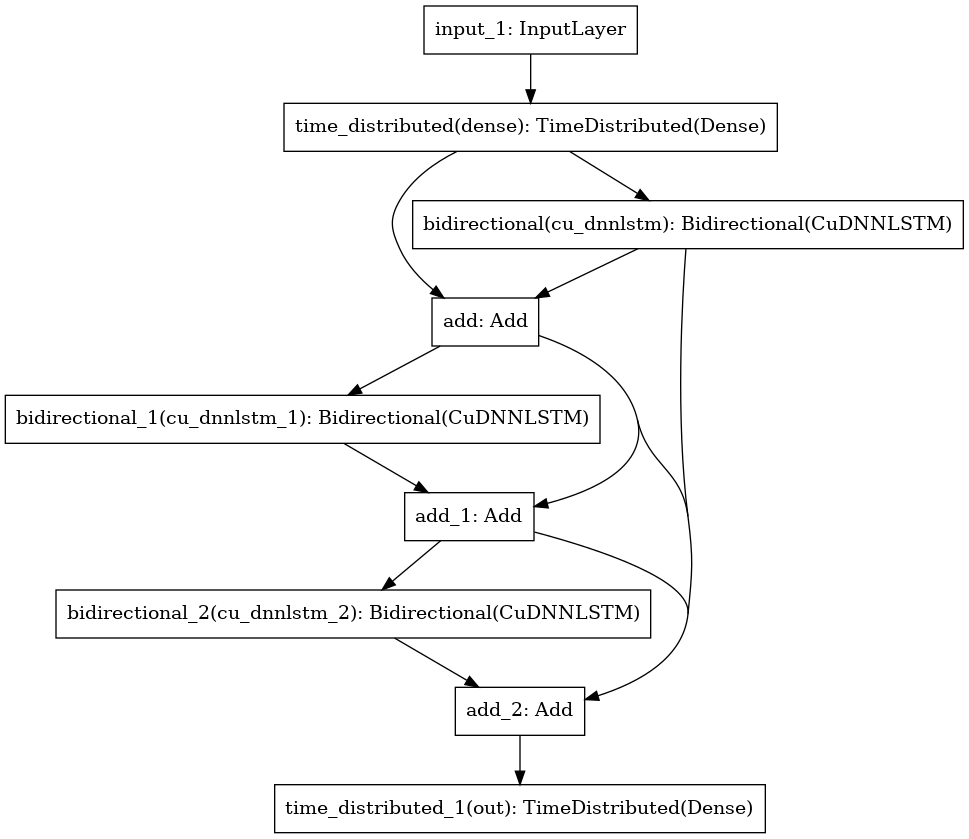

In [31]:
import tensorflow.keras.losses
n_units = int(numFeatures/2)+1
n_in_out = numFeatures

print(n_units)
print(n_in_out)

def build_model():

    inputs = tf.keras.Input(shape=[None,257])
    x = inputs
    x = ((tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(258,activation='linear'))))(x)
    # #---------------------------------------------------------------------------------------------------------------
    block_0_output = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True,input_shape=(None,n_in_out))))(x)
    block_1_output = tf.keras.layers.add([x, block_0_output]) 
    
    x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(block_1_output)
    block_2_output = tf.keras.layers.add([x,block_1_output])  
        
           
    x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(block_2_output)
#     block_3_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_3_out',activation='relu')))(x)
    block_3_output = tf.keras.layers.add([x,block_0_output,block_1_output,block_2_output])
    
#     x = tf.keras.layers.Dropout(0.5)(block_3_output)
    
#     x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(block_3_output)
# #     block_4_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_4_out',activation='relu')))(x
#     block_4_output = tf.keras.layers.add([x,block_2_output, block_3_output])
     
# #     x = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_in_out*2,activation='tanh')))(x)
    
            
#     x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(block_4_output)
# # #     block_5_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_5_out',activation='relu')))(x)
#     block_5_output = tf.keras.layers.add([x,block_3_output, block_4_output])
        
            
#     x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(block_5_output)
# #     block_6_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_6_out',activation='relu')))(x)
#     block_6_output = tf.keras.layers.add([x, block_4_output,block_5_output])
    

#     x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(block_6_output)
# #     block_7_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_7_out',activation='relu')))(x)
#     block_7_output = tf.keras.layers.add([x, block_5_output,block_6_output])
    
#     x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(block_7_output)
# #     block_8_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_8_out',activation='relu')))(x)
#     block_8_output = tf.keras.layers.add([x, block_6_output,block_7_output])
    
#     x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(block_8_output)
# #     block_9_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_9_out',activation='relu')))(x)
#     block_9_output = tf.keras.layers.add([x, block_7_output,block_8_output])
# #     x = (tf.keras.layers.Dropout(0.5))(x)

#     x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(block_9_output)
# #     block_10_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_10_out',activation='relu')))(x)
#     block_10_output = tf.keras.layers.add([x, block_8_output,block_9_output])
                                                                                   
    out = ((tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(257,name='out',activation='linear',))))(block_3_output)                                                  
    model = tf.keras.models.Model(inputs=inputs, outputs=(out),name="Test_Build")
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    loss = loss='mse'
    model.compile(optimizer=optimizer, loss=loss, 
                    metrics=['accuracy','mse'])
    return model


model=build_model()
model.summary()
tf.keras.utils.plot_model(model, "model.png", show_shapes=False,expand_nested=False, dpi=96,show_layer_names=True)
# gc.collect()

In [32]:
# import tensorflow.keras.losses
# n_units = int(numFeatures/2)+1
# n_in_out = numFeatures


# def build_model():

#     inputs = tf.keras.Input(shape=[None,n_in_out])
#     x = inputs
#     # #---------------------------------------------------------------------------------------------------------------
#     block_1_output = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True,input_shape=(None,n_in_out))))(x)
# #      block_1_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_1_out',activation='relu')))(x)
    
#     x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(x)
# #     block_2_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_2_out',activation='relu')))(x) 
        
           
#     x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(x)
# #     block_3_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_3_out',activation='relu')))(x)

    
    
    
#     x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(x)
# # #     block_4_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_4_out',activation='relu')))(x

     
# # #     x = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_in_out*2,activation='tanh')))(x)
    
            
# #     x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(x)
# # # #     block_5_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_5_out',activation='relu')))(x)

        
            
# #     x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(x)
# #     block_6_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_6_out',activation='relu')))(x)

    

# #     x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(block_6_output)
# # #     block_7_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_7_out',activation='relu')))(x)
# #     block_7_output = tf.keras.layers.add([x, block_5_output,block_6_output])
    
# #     x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(block_7_output)
# # #     block_8_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_8_out',activation='relu')))(x)
# #     block_8_output = tf.keras.layers.add([x, block_6_output,block_7_output])
    
# #     x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(block_8_output)
# # #     block_9_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_9_out',activation='relu')))(x)
# #     block_9_output = tf.keras.layers.add([x, block_7_output,block_8_output])
# # #     x = (tf.keras.layers.Dropout(0.5))(x)

# #     x = (tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(n_units,return_sequences=True)))(block_9_output)
# # #     block_10_output = (tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(129,name='Block_10_out',activation='relu')))(x)
# #     block_10_output = tf.keras.layers.add([x, block_8_output,block_9_output])
                                                                                   
#     out = ((tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_in_out,name='out',activation='linear',))))(x)                                                  
#     model = tf.keras.models.Model(inputs=inputs, outputs=(out),name="Test_Build")
# #     optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
#     loss = loss='mse'
#     model.compile(optimizer=optimizer, loss=loss, 
#                     metrics=['accuracy','mse'])
#     return model


# model=build_model()
# model.summary()
# tf.keras.utils.plot_model(model, "model.png", show_shapes=False,expand_nested=False, dpi=96,show_layer_names=True)
# # gc.collect()

In [223]:
train_voiceFiles = train_mozilla_voice
train_noiseFiles = train_u8k_noise_paths
batch_size = 1
validation_voiceFiles = test_mozilla_voice
validation_noiseFiles = validation_u8k_noise_paths

trainDataGen = KerasSequenceGenerator2(voiceArray=train_voiceFiles,
                                       noiseArray=train_noiseFiles,
                                       batch_size=batch_size,
                                       maxNoiseAdjust=0.75,
                                       shuffle=True)   

valDataGen =  KerasSequenceGenerator2(voiceArray=validation_voiceFiles,
                                      noiseArray=validation_noiseFiles,
                                      batch_size=batch_size,
                                      maxNoiseAdjust=0,
                                      shuffle=True)
gc.collect()

0

In [224]:
import multiprocessing
logdir="/docker_ws/tb_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = tf.keras.callbacks.TensorBoard(log_dir=logdir,write_graph=False,write_images=False,histogram_freq=1,update_freq='epoch')
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.005, patience=3, mode='min',verbose=1,restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint('Best_Model.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', mode='min',save_best_only=True, verbose=1)
# pl = plot
history=model.fit(trainDataGen,
          epochs=50,
          verbose=1,
#           shuffle=True,
#           batch_size = 10,
#           steps_per_epoch=len(train_noiseFiles)/batch_size,
          validation_data=(valDataGen),
#           validation_steps=len(validation_voiceFiles)/batch_size,
          max_queue_size=100,
          use_multiprocessing=False,
          workers=multiprocessing.cpu_count(),
          callbacks=[es,mc])
gc.collect()

Train for 7000 steps, validate for 1500 steps
Epoch 1/50
6998/7000 [============================>.] - ETA: 0s - loss: 0.2170 - accuracy: 0.4332 - mse: 0.2177
Epoch 00001: val_loss improved from inf to 0.39563, saving model to Best_Model.01-0.40.h5
7000/7000 [==============================] - 514s 73ms/step - loss: 0.2169 - accuracy: 0.4332 - mse: 0.2176 - val_loss: 0.3956 - val_accuracy: 0.3216 - val_mse: 0.3959
Epoch 2/50
6999/7000 [============================>.] - ETA: 0s - loss: 0.0759 - accuracy: 0.4940 - mse: 0.0759
Epoch 00002: val_loss improved from 0.39563 to 0.34191, saving model to Best_Model.02-0.34.h5
7000/7000 [==============================] - 523s 75ms/step - loss: 0.0759 - accuracy: 0.4940 - mse: 0.0759 - val_loss: 0.3419 - val_accuracy: 0.3349 - val_mse: 0.3441
Epoch 3/50
6998/7000 [============================>.] - ETA: 0s - loss: 0.0576 - accuracy: 0.5105 - mse: 0.0575
Epoch 00003: val_loss improved from 0.34191 to 0.29805, saving model to Best_Model.03-0.30.h5
7000

569

In [218]:
# model = tf.keras.models.load_model('Best_Model.04-0.16.h5')
# model.save('final_final_final_static_vol.h5')

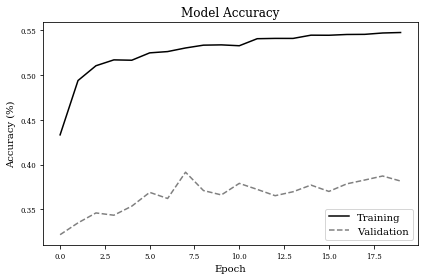

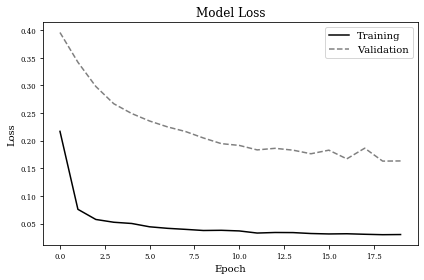

In [225]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.plot(history.history['accuracy'],color='k', ls='solid')
plt.plot(history.history['val_accuracy'],color='0.50', ls='dashed')
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.tight_layout()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'],color='k', ls='solid')
plt.plot(history.history['val_loss'],color='0.50', ls='dashed')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()
# plt.gca().spines['top'].visible(False)
# plt.gca().spines['right'].set_position('zero')


In [426]:
for i in u8k_air_conditioner:
    u8k_air_conditioner2.
    

[('/docker_ws/Datasets/UrbanSound8K/audio/fold10/39847-5-1-0.wav', 5), ('/docker_ws/Datasets/UrbanSound8K/audio/fold10/102857-5-0-19.wav', 5), ('/docker_ws/Datasets/UrbanSound8K/audio/fold10/181624-4-0-0.wav', 4), ('/docker_ws/Datasets/UrbanSound8K/audio/fold10/100648-1-1-0.wav', 1), ('/docker_ws/Datasets/UrbanSound8K/audio/fold10/200460-6-5-0.wav', 6), ('/docker_ws/Datasets/UrbanSound8K/audio/fold10/101382-2-0-20.wav', 2), ('/docker_ws/Datasets/UrbanSound8K/audio/fold10/209672-3-3-0.wav', 3), ('/docker_ws/Datasets/UrbanSound8K/audio/fold10/167750-4-1-0.wav', 4), ('/docker_ws/Datasets/UrbanSound8K/audio/fold10/102857-5-0-16.wav', 5), ('/docker_ws/Datasets/UrbanSound8K/audio/fold10/188497-2-0-0.wav', 2), ('/docker_ws/Datasets/UrbanSound8K/audio/fold10/200786-5-1-3.wav', 5), ('/docker_ws/Datasets/UrbanSound8K/audio/fold10/102103-3-1-0.wav', 3), ('/docker_ws/Datasets/UrbanSound8K/audio/fold10/199261-3-0-4.wav', 3), ('/docker_ws/Datasets/UrbanSound8K/audio/fold10/208652-8-6-0.wav', 8), ('/

# Model Evaluation

In [446]:
# BatchSize_test = len(test_mir_voice_paths)
# vBatchSize = 50

# NoiseFiles = test_u8k_noise
NoiseFiles = u8k_street_music
CleanFiles = test_mir_voice_paths


testDataGen = KerasSequenceGenerator2(voiceArray=CleanFiles,
                                     noiseArray=NoiseFiles,
                                     batch_size=1)

test_results = model.evaluate(testDataGen,
                              workers=100)


gc.collect()

100/100 [==============================] - 5s 49ms/step - loss: 0.3092 - accuracy: 0.4916 - mse: 0.3112


117

In [445]:
print(test_results)

[0.31490744665265086, 0.5599474, 0.31111926]


In [187]:
# train_mir_voice
import utils
from utils import WavFileHelper as WavFileHelper
import gc
gc.collect()

PESQ_Scores = []
STOI_Scores = []

def get_stft(audio):
    cleanAudioFeatureExtractor = FeatureExtraction(audio, windowLength=windowLength,
                                                            overlap=overlap, sample_rate=fs)
    clean_stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()        
    mag = np.abs(clean_stft_features)
    ang = np.angle(clean_stft_features)
    mean = np.mean(clean_stft_features)
    std = np.std(clean_stft_features)

    stft =  (((mag - mean) / std))        
    stft = np.vstack(stft.T)
    
    return stft,ang

def get_audio(stft):
    audio = librosa.istft(stft, win_length=windowLength,hop_length=overlap,window=scipy.signal.hanning(512, sym=False), center=True) 
    return audio
    
def compute_STOI(clean_signal, noisy_signal, sr=16000):
    return stoi(clean_signal, noisy_signal, sr, extended=False)

def compute_PESQ(clean_signal, noisy_signal, sr=16000):
    return pesq2.pesq(sr,clean_signal, noisy_signal,'wb')
# (pesq(rate, ref, deg, 'wb')

def compute_SNR(a, axis, ddof): 
    a = np.asanyarray(a) 
    m = a.mean(axis) 
    sd = a.std(axis = axis, ddof = ddof) 
    return np.where(sd == 0, 0, m / sd) 

def findRMS(vector):
    return np.sqrt(np.mean(np.power(vector,2,dtype='float32')))


def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def make_prediction(mixed, restore_phase=True):
    stft,ang = get_stft(mixed)
    stft = stft.reshape(1,np.size(stft,0),np.size(stft,1))
    prediction = model.predict(stft)
    prediction = np.squeeze(prediction,axis=0).T
    if restore_phase == True:
        
        
        rp_prediction = prediction*np.exp(1j*ang)
        return rp_prediction
    
    return prediction
gc.collect()

0

# Model Evaluation

In [40]:
    def data_generation():   

        fs = 16000
        lowcut = 340
        highcut = 3400

        cleanRootDir = mirV_root
        cleanAudioFolder = mymir_voice
        noiseRootDir = u8k_root
        noiseAudioFolder = u8k_filepaths

        randomCleanFilePath = os.path.join(cleanRootDir,random.choice(cleanAudioFolder))
        randomCleanWav,_  = librosa.load(randomCleanFilePath,sr=16000,mono=True,dtype=np.float32)

        randomNoiseFilePath = os.path.join(noiseRootDir,random.choice(noiseAudioFolder))
        randomNoiseWav,_ = librosa.load(randomNoiseFilePath,sr=16000,mono=True,dtype=np.float32)

        randomCleanWav,mixedWav = WavFileHelper.add_noise_to_clean_audio(randomCleanWav,randomNoiseWav)



        print('clean: '+ randomCleanFilePath + str(randomCleanWav.shape))
    #         randomCleanWav = librosa.util.normalize(randomCleanWav,fill=False)
        cleanAudioFeatureExtractor = FeatureExtraction(randomCleanWav, windowLength=windowLength,
                                                        overlap=overlap, sample_rate=fs)


        clean_stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()        
        clean_stft_mag = np.abs(clean_stft_features)

        clean_stft_mean = np.mean(clean_stft_features)
        clean_stft_std = np.std(clean_stft_features)

        clean_stft_mean = np.mean(clean_stft_features)
        clean_stft_std = np.std(clean_stft_features)

        clean_stft =  (((clean_stft_mag - clean_stft_mean) / clean_stft_std))        
        clean_stft = np.vstack(clean_stft.T)
        clean_stft = clean_stft.reshape(1,np.size(clean_stft,0),np.size(clean_stft,1))




        print('noise: '+randomNoiseFilePath + str(randomNoiseWav.shape))

        print(mixedWav.shape)
    #         mixedWav = librosa.util.normalize(mixedWav,fill=False)

        mixedAudioFeatureExtractor = FeatureExtraction((mixedWav), windowLength=windowLength,
                                                        overlap=overlap, sample_rate=fs)
        mixed_stft_features = mixedAudioFeatureExtractor.get_stft_spectrogram()
        mixed_stft_mag = np.abs(mixed_stft_features)
        mixed_stft_mean = np.mean(mixed_stft_features)
        mixed_stft_std = np.std(mixed_stft_features)

        mixed_stft =  (((mixed_stft_mag - mixed_stft_mean) / mixed_stft_std))
        mixed_stft = np.vstack(mixed_stft.T)
        mixed_stft = mixed_stft.reshape(1,np.size(mixed_stft,0),np.size(mixed_stft,1))     

        return mixed_stft, clean_stft
    
    
    def plot_spectrogram(signal, title):
        fig, ax = plt.subplots(figsize=(20, 4))
        cax = ax.matshow(
            signal,
            origin="lower",
            aspect="auto",
            cmap=plt.cm.seismic,
            vmin=-1 * np.max(np.abs(signal)),
            vmax=np.max(np.abs(signal)),
        )
        fig.colorbar(cax)
#         ax.set_title(title)
        plt.tight_layout()
        plt.show()
        
           
    def butterFilter(lowFreq,highFreq,fs,audioArray):
        lo=lowFreq
        hi=highFreq
        sr=fs
        y=audioArray

        b,a=signal.butter(N=6, Wn=[2*lo/sr, 2*hi/sr], btype='band')
        x = signal.lfilter(b,a,y)

        return x

    def timePlot(signalToPlot,sampleRate,plotLabel):

        time_step = np.arange(0, len(signalToPlot)/sampleRate, 1/sampleRate)
        sig = (signalToPlot)

        plt.figure(figsize=(16, 5))
        plt.plot(time_step, sig, linewidth=3, label=plotLabel)
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.legend(loc='best')
        


    def butterFilter(lowFreq,highFreq,fs,audioArray):
        lo=lowFreq
        hi=highFreq
        sr=fs
        y=audioArray

        coeffs=signal.butter(3, Wn=[2*lo/sr, 2*hi/sr], btype='band',output='sos')
        x = signal.sosfiltfilt(coeffs,y,padtype='even',padlen=0)

        return x

    def layeredPlot(signal1,signal2,sampleRate,label1,label2):
        signal1 = signal1
        signal2 = signal2

        if len(signal1) > len(signal2):
            signal1 = signal1[0:len(signal2)]
        if len(signal2) > len(signal1):
            signal2 = signal2[0:len(signal1)]
        else:
            pass


        sampleRate = sampleRate
        time_vec = np.arange(0, len(signal2)/sampleRate, 1/sampleRate)


        plt.figure(figsize=(16, 5))
        plt.plot(time_vec, signal2, linewidth=3, label=label1, alpha=0.8)
        plt.plot(time_vec, signal1, linewidth=3, label=label2, alpha=0.8)
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')

        plt.legend(loc='best')
        
    
    

In [44]:
classDict = {
    9:"street_music",
    8: "siren",
    7: "jackhammer",
    6: "gun_shot",
    5: "engine_idling",
    4: "drilling",
    3: "dog_bark",
    2: "children_playing",
    1: "car_horn",
    0: "air_conditioner"
}    



listOfClasses = []
 
u = 0    
u8k_air_conditioner = []    
for i in test_u8k_labelledFilenamesList:
    if i[1] == [u]:
        u8k_air_conditioner.append(i)
print(len(u8k_air_conditioner))   
listOfClasses.append(u8k_air_conditioner)

u+=1   
u8k_car_horn = []
for i in test_u8k_labelledFilenamesList:
    if i[1] == [u]:
        u8k_car_horn.append(i)
print(len(u8k_car_horn))
listOfClasses.append(u8k_car_horn)
u+=1
u8k_children_playing = []
for i in test_u8k_labelledFilenamesList:
    if i[1] == [u]:
        u8k_children_playing.append(i)
print(len(u8k_children_playing))
listOfClasses.append(u8k_children_playing)
u+=1
u8k_dog_bark = []
for i in test_u8k_labelledFilenamesList:
    if i[1] == [u]:
        u8k_dog_bark.append(i)
print(len(u8k_dog_bark))
listOfClasses.append(u8k_dog_bark)

u+=1
u8k_drilling = []
for i in test_u8k_labelledFilenamesList:
    if i[1] == [u]:
        u8k_drilling.append(i)
print(len(u8k_drilling))

listOfClasses.append(u8k_drilling)
u+=1
u8k_engine_idling = []
for i in test_u8k_labelledFilenamesList:
    if i[1] == [u]:
        u8k_engine_idling.append(i)
print(len(u8k_engine_idling))
listOfClasses.append(u8k_engine_idling)
u+=1
u8k_gun_shot = []
for i in test_u8k_labelledFilenamesList:
    if i[1] == [u]:
        u8k_gun_shot.append(i)
print(len(u8k_gun_shot))
listOfClasses.append(u8k_gun_shot)

u+=1
u8k_jackhammer = []
for i in test_u8k_labelledFilenamesList:
    if i[1] == [u]:
        u8k_jackhammer.append(i)
print(len(u8k_jackhammer))
listOfClasses.append(u8k_jackhammer)

u+=1
u8k_siren = []
for i in test_u8k_labelledFilenamesList:
    if i[1] == [u]:
        u8k_siren.append(i)
print(len(u8k_siren))
listOfClasses.append(u8k_siren)

u+=1
u8k_street_music = []
for i in test_u8k_labelledFilenamesList:
    if i[1] == [u]:
        u8k_street_music.append(i)
print(len(u8k_street_music))
listOfClasses.append(u8k_street_music)

100
33
100
100
100
93
32
96
83
100


 # Evaluation of performance for each U8K noise class

In [37]:
#This cell takes a very long time!


# print(len(test_mir_voice_paths))
from IPython.display import clear_output, display
results = []
STOI_Scores = []
SNR_Scores = []
PESQ_Scores = []

def read_audio(filepath, sample_rate=16000, normalize=True):
    audio, sr = librosa.load(filepath, sr=16000,mono=True,dtype=np.float32)

    if normalize:
                audio = librosa.util.normalize(audio,fill=False)

    return audio,sr 


def add_noise_to_clean_audio(clean_audio, noise_signal):
    
    if len(clean_audio) > len(noise_signal):
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)
        noise_signal = noise_signal[0:len(clean_audio)]

    if len(noise_signal) > len(clean_audio):
        while len(noise_signal) >= len(clean_audio):
            clean_audio = np.append(clean_audio, clean_audio)
        clean_audio = clean_audio[0:len(noise_signal)]
        

    
    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noise_signal ** 2)
    noisyAudio = (clean_audio + np.sqrt(speech_power / noise_power) * noise_signal)
    noisyAudio = np.asarray(noisyAudio,dtype=np.float32)
    return clean_audio,noisyAudio,noise_signal

for classList in (listOfClasses):
#     clear_output(wait=True)
    
    for idx,i in tqdm(enumerate(classList),total=len(classList)):


        clean,sr = read_audio(test_mir_voice_paths[idx],16000)

        noiseFile = (i[0])
        noiseClass = (i[1])
        noise,sr = read_audio(noiseFile,16000)

        clean,mixed,noise = add_noise_to_clean_audio(clean,noise)
        clean = librosa.util.normalize(clean,fill=False)
        mixed = librosa.util.normalize(mixed,fill=False)

        prediction = make_prediction(mixed)

        mag_only_prediction = make_prediction(mixed, restore_phase=False)
        mag_only_audio = get_audio(mag_only_prediction)

        prediction_audio = get_audio(prediction)
    #     prediction_audio = librosa.util.normalize(prediction_audio,fill=False)
        


#         PESQScore = compute_PESQ(prediction_audio[0:len(mixed)],mixed,16000)
#         PESQ_Scores.append(PESQScore)
#         print("PESQ:" +str(PESQScore))


        SNR_Score  = 20*np.log(findRMS(prediction_audio)/findRMS(noise))
        SNR_Scores.append(SNR_Score)
#         print("SNR:" +str(SNR_Score))


        STOIScore = compute_STOI(clean[0:len(prediction_audio)],prediction_audio)
        STOI_Scores.append(STOIScore)
#         print("STOI:" +str(STOIScore))



        results.append([STOIScore,SNR_Score,PESQ_Score,noiseClass])
    
#     print(str(i[1] + 'Complete'))
#         clear_output(wait=True)
#         print(classList[0][1])
#     clear_output(wait=True)
    # return np.sqrt(np.mean(np.square(amp), axis=-1))   
    # print(clean)

#     AVG_SNR = round(sum(SNR_Scores)/len(SNR_Scores),3)
#     AVG_STOI = round(sum(STOI_Scores)/len(STOI_Scores),3)
#     AVG_PESQ = round(sum(PESQ_Scores)/len(PESQ_Scores),3)

gc.collect()


NameError: name 'listOfClasses' is not defined

In [531]:
# logSNR = 10*np.log10(AVG_SNR)

# mse = np.sum((prediction_audio-clean[:len(prediction_audio)])**2 ) / 1000.0
# print(logSNR)
# print(AVG_STOI)
# print(AVG_PESQ)

# gc.collect()

print(len(listOfClasses[1]))

33


In [540]:
for x in range(10):
    whichClass = [x]
    className = classDict[x]
    STOI_Scores = []
    SNR_Scores = []
    AVG_SNR = []
    AVG_STOI = []
    
    for i in results:
        if i[3] == whichClass:
            STOI_Scores.append(i[0])
            SNR_Scores.append(i[1])
        else:
            continue
#             pri /nt('poo')
#             print(className)
            
#         print(STOI_Scores)
        AVG_SNR = round(sum(SNR_Scores)/len(SNR_Scores),3)
        AVG_STOI = round(sum(STOI_Scores)/len(STOI_Scores),3)
    
    print(className + ' AVG SNR = '+str(AVG_SNR))
    print(className + ' AVG STOI = ' + str(AVG_STOI))

air_conditioner AVG SNR = -22.337
air_conditioner AVG STOI = 0.532
car_horn AVG SNR = -23.243
car_horn AVG STOI = 0.535
children_playing AVG SNR = -15.627
children_playing AVG STOI = 0.517
dog_bark AVG SNR = -15.673
dog_bark AVG STOI = 0.54
drilling AVG SNR = -20.616
drilling AVG STOI = 0.517
engine_idling AVG SNR = -29.433
engine_idling AVG STOI = 0.582
gun_shot AVG SNR = 5.625
gun_shot AVG STOI = 0.597
jackhammer AVG SNR = -14.275
jackhammer AVG STOI = 0.499
siren AVG SNR = -17.398
siren AVG STOI = 0.54
street_music AVG SNR = -19.739
street_music AVG STOI = 0.489


In [497]:
g = results[1]

print(g[2])

<function PESQ_Score at 0x7f489c32c730>


In [362]:
print(findRMS(clean))
print(findRMS(mixed))
print(findRMS(noise))
print(findRMS(prediction_audio))

# clean = librosa.util.normalize(clean,fill=False)
# mixed = librosa.util.normalize(mixed,fill=False)
# noise = librosa.util.normalize(noise,fill=False)

print(np.max(clean))
print(np.max(mixed))
print(np.max(noise))
print(np.max(prediction_audio))

print(10*np.log10(np.std(SNR_Scores)))
SNR = 20*np.log(findRMS(clean)/findRMS(noise))
print(SNR)

# WavFileHelper.play_audio(mixed,16000,0)

0.08348697
0.11803262
0.1198972
0.060494713
0.9945825
0.93061525
0.91253704
0.72818714
-7.238883376121521


In [228]:
# # from scipy import stats 
# # print(results)
# AVG_SNR = round(sum(SNR_Scores)/len(SNR_Scores),3)
# AVG_STOI = round(sum(STOI_Scores)/len(STOI_Scores),3)
# AVG_PESQ = round(sum(PESQ_Scores)/len(PESQ_Scores),3)

# print(AVG_SNR)
# print(AVG_STOI)
# print(AVG_PESQ)
# # print(len(u8k_car_horn))
# # print(STOI_Scores)

# # WavFileHelper.play_audio(mixed,16000,0)

# # print(np.std(SNR_Scores))

# # print(10*np.log10(np.std(SNR_Scores)))

# # clean_power = prediction_audio**2
# # noise_power = noise[0:len(prediction_audio)]**2
# # #
# # scipy.stats.signaltonoise(clean_power, axis=0, ddof=0)

0.007
0.597
1.493
0.030387901222587665
-15.172992939616725


# Audio Playback & Plots

In [68]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
def f(x):
    return x

#test_u8k_filepaths
cleanPath = test_mozilla_voice[random.randint(0,len(test_mozilla_voice))]
noisePath = test_u8k_filepaths[random.randint(0,len(test_u8k_filepaths))]
clean,sr =  read_audio(cleanPath,16000)
clean = librosa.util.normalize(clean,fill=False)
noise,sr = read_audio(noisePath,16000)
noise = librosa.util.normalize(noise,fill=False)
clean,mixed,noise = add_noise_to_clean_audio(clean,noise)

# print(clean)
# print(noise)
# print(mixed)

# mixed = mixed - 3
prediction = make_prediction(mixed)

mag_only_prediction = make_prediction(mixed, restore_phase=False)
mag_only_audio = get_audio(mag_only_prediction)

prediction_audio = get_audio(prediction)
# prediction_audio = librosa.util.normalize(prediction_audio,fill=False)


# WavFileHelper.play_audio(prediction_audio,16000,0)

# print(z.shape)

# print(cleanPath)
# print(noisePath)
# '/docker_ws/Datasets/Mozilla/clips/train/common_voice_en_19537014.wav'
# '/docker_ws/Datasets/UrbanSound8K/audio/fold10/102857-5-0-14.wav'

NameError: name 'make_prediction' is not defined

In [66]:
# %%timeit -n10
# prediction = make_prediction(mixed)


# Noise Audio

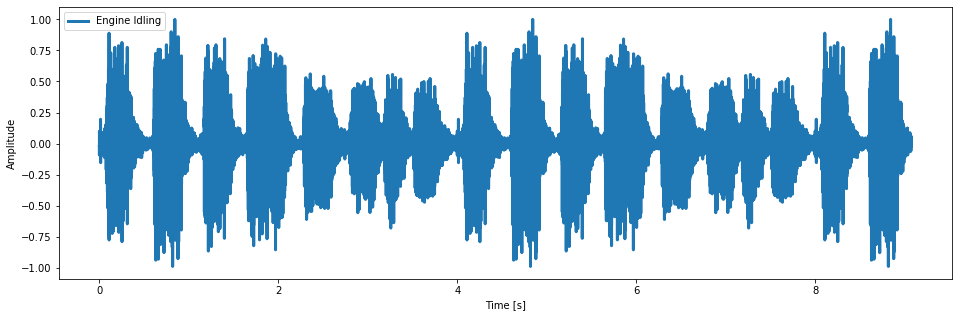

In [67]:
timePlot(noise,16000,'Engine Idling')

# Noisy Audio

In [406]:
WavFileHelper.play_audio(mixed,16000,0)


# Denoised Audio + Phase from noisy audio

In [407]:
WavFileHelper.play_audio(prediction_audio,16000,0)


# Denoised Audio + Phase Griffin-Lim Computed Phase

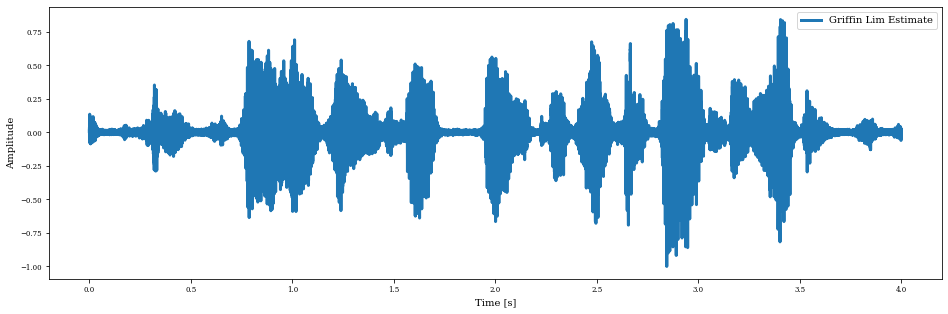

In [408]:
GriffinLim = librosa.core.griffinlim(mag_only_prediction, n_iter=100,win_length=windowLength,hop_length=overlap,window=scipy.signal.hanning(512, sym=False),center=True,init=None)
    # GriffinLim = librosa.core.griffinlim(mag_only_prediction, win_length=windowLength,hop_length=overlap,window=scipy.signal.hanning,center=True,init='random')
GriffinLim = librosa.util.normalize(GriffinLim)
timePlot(GriffinLim,16000,'Griffin Lim Estimate')


WavFileHelper.play_audio(GriffinLim,16000,0)

In [409]:
WavFileHelper.play_audio(clean,16000,0)


In [364]:
# %%timeit -n1
# GriffinLim = librosa.core.griffinlim(mag_only_prediction, n_iter=10,win_length=windowLength,hop_length=overlap,window=scipy.signal.hanning,center=True,init=None)
   

88.4 ms ± 4.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


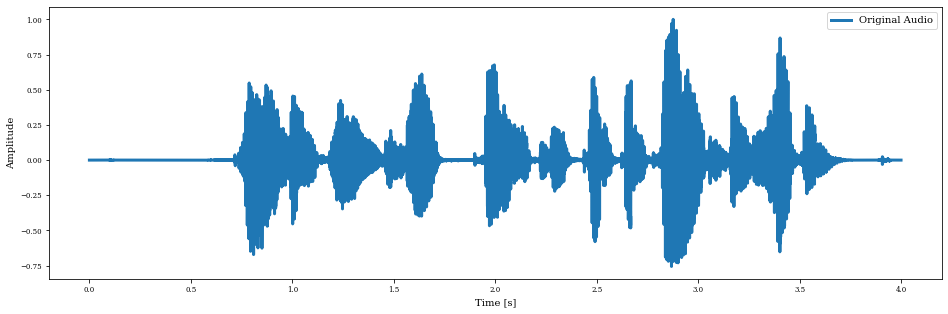

In [410]:
timePlot(clean,16000,'Original Audio')
WavFileHelper.play_audio(mixed,16000,0)

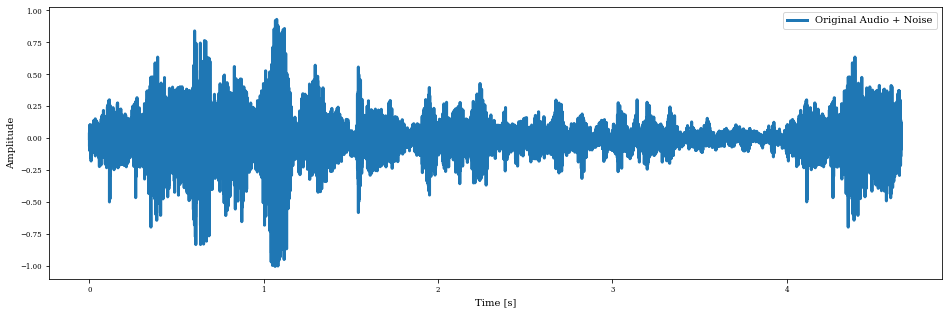

In [366]:
timePlot(mixed,16000,'Original Audio + Noise')
WavFileHelper.play_audio((mixed),16000,0)

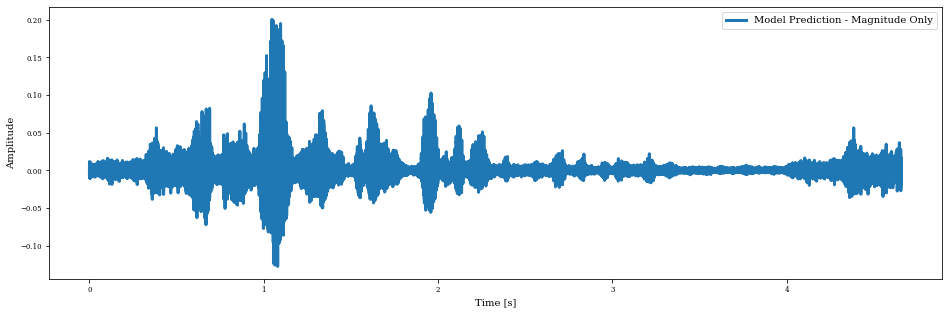

In [367]:
# magOnlyAudio = librosa.util.normalize(magOnlyAudio)/2

timePlot(mag_only_audio,16000, 'Model Prediction - Magnitude Only') 
WavFileHelper.play_audio(mag_only_audio,16000,0)

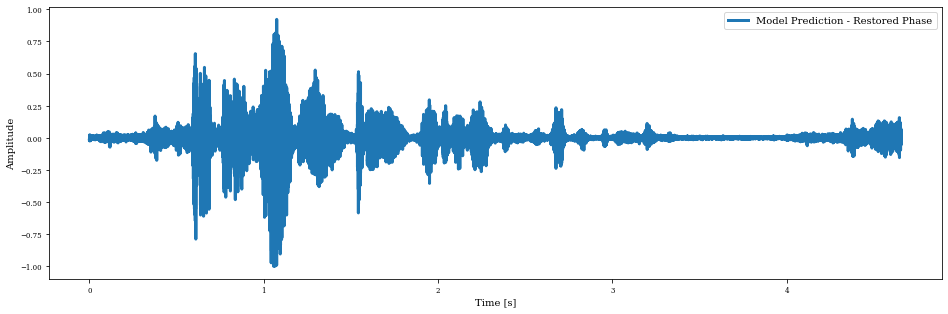

In [368]:
prediction_audio = librosa.util.normalize(prediction_audio)
timePlot(prediction_audio,16000,'Model Prediction - Restored Phase')
WavFileHelper.play_audio(prediction_audio,16000,0)

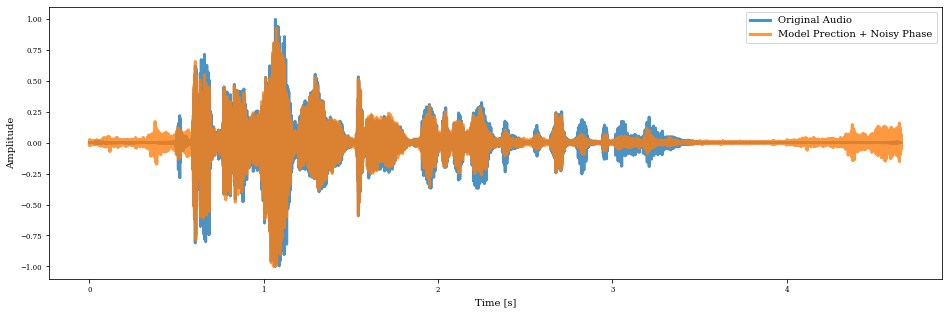

In [369]:
layeredPlot(librosa.util.normalize(prediction_audio),clean,16000,'Original Audio','Model Prection + Noisy Phase')

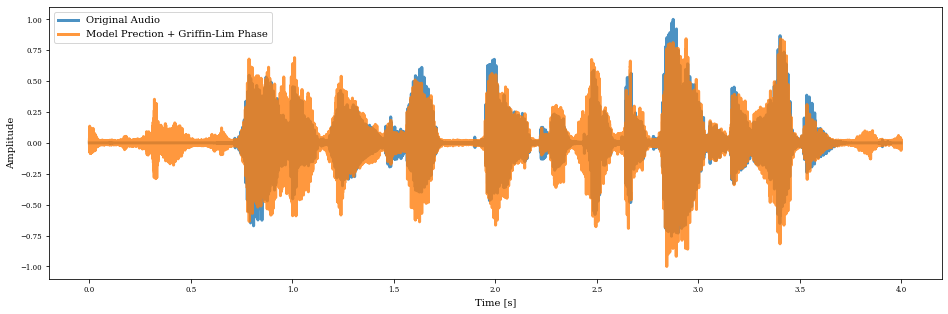

In [411]:
layeredPlot(librosa.util.normalize(GriffinLim),clean,16000,'Original Audio','Model Prection + Griffin-Lim Phase')

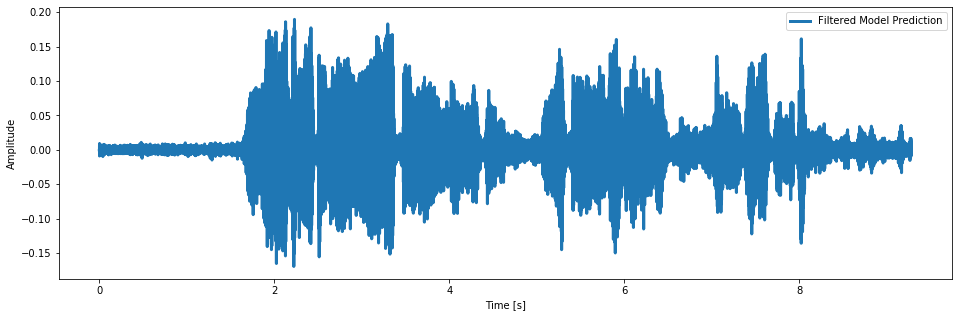

In [109]:
ButterFiltered=WavFileHelper.butterFilter(300,3000,16000,prediction_audio)


WavFileHelper.timePlot(ButterFiltered,16000,'Filtered Model Prediction')

WavFileHelper.play_audio(ButterFiltered,16000,0)

In [ ]:
# import noisereduce as nr
# noiseReducedFile = nr.reduce_noise(audio_clip=restoredPhaseAudio,noise_clip=restoredPhaseAudio[0:],
#                                              verbose=False,prop_decrease=0.9,use_tensorflow=True)

In [ ]:
# WavFileHelper.timePlot(noiseReducedFile,16000,'NR Filtered Signal')
# WavFileHelper.play_audio(noiseReducedFile,16000,0)

In [ ]:
# librosa.output.write_wav('/docker_ws/noisereducedfile',noiseReducedFile,16000)
# librosa.output.write_wav('/docker_ws/mixedAudio',mixedAudio,16000)
# librosa.output.write_wav('/docker_ws/restoredPhaseAudio',restoredPhaseAudio,16000)

In [ ]:
# print(random.gauss(4, 25/3))

In [ ]:
# import matplotlib.pyplot as plt
# y=(mixed)
# plt.figure(figsize=(12, 8))
# D = librosa.amplitude_to_db((y), ref=np.max)
# # plt.subplot(4, 2, 1)
# librosa.display.specshow(D, y_axis='linear')
# # plt.colorbar(format='%+2.0f dB')
# # plt.title('Linear-frequency power spectrogram')

(501, 257)


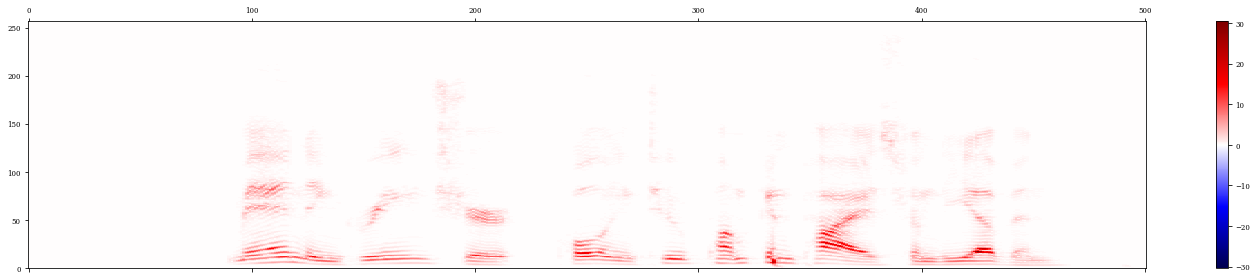

In [419]:
cleanstft,ang = get_stft(clean)
print(cleanstft.shape)
# cleanstft = np.asarray(cleanstft).T
plot_spectrogram(np.abs(cleanstft.T),'')

(501, 257)


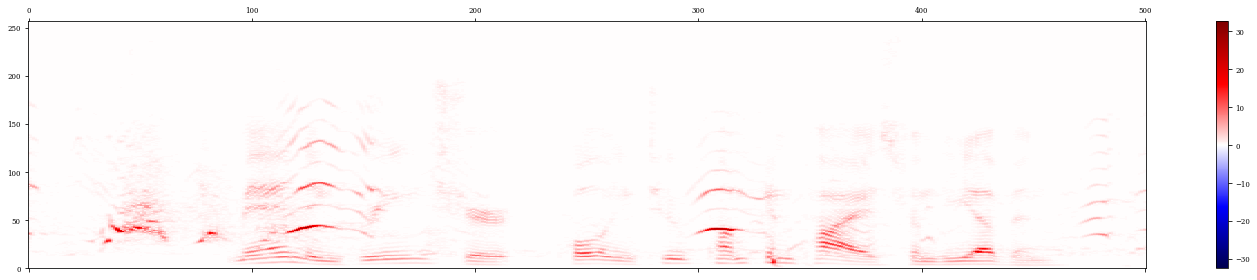

In [420]:
mixedstft,ang = get_stft(mixed)
print(mixedstft.shape)
# cleanstft = np.asarray(cleanstft).T
plot_spectrogram(np.abs(mixedstft.T),'')

(257, 501)


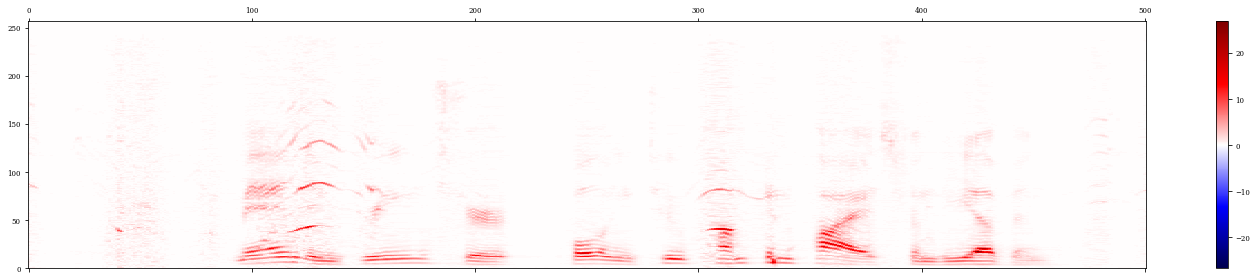

In [421]:
# mag_only_audio,ang = get_stft(mixed)
print(mag_only_prediction.shape)
# cleanstft = np.asarray(cleanstft).T
plot_spectrogram(np.abs(mag_only_prediction),'')

(257, 501)


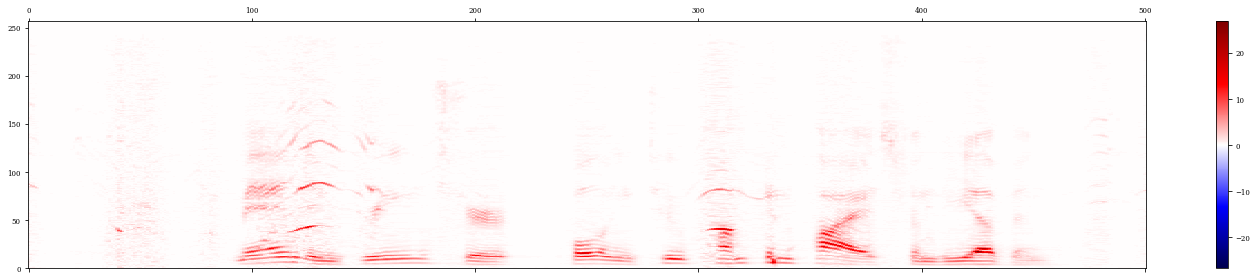

In [422]:
# mag_only_audio,ang = get_stft(mixed)
print(mag_only_prediction.shape)
# cleanstft = np.asarray(cleanstft).T
plot_spectrogram(np.abs(mag_only_prediction),'')

(257, 501)


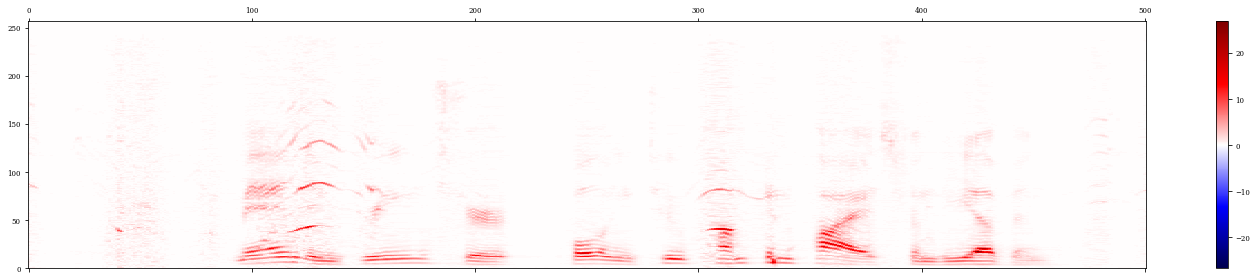

In [423]:
# mag_only_audio,ang = get_stft(mixed)
print(prediction.shape)
# cleanstft = np.asarray(cleanstft).T
plot_spectrogram(np.abs(prediction),'')

In [417]:
plt.figure(figsize=(12, 8))
librosa.display.specshow(D, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

NameError: name 'D' is not defined

<Figure size 864x576 with 0 Axes>

In [ ]:
f, t, Sxx = signal.spectrogram(clean, 16000)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Clean Spectogram')
plt.show()


In [ ]:
f, t, Sxx = signal.spectrogram(mixed, 16000)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


In [ ]:
f, t, Sxx = signal.spectrogram(magOnlyAudio, 16000)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
f, t, Sxx = signal.spectrogram(prediction_audio, 16000)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
%matplotlib inline
# CA2=WavFileHelper.butterFilter(340,3400,16000,cleanAudio)
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = len(clean)
Fs = 16000
T = 1.0 / Fs
x = np.linspace(0.0, N*T, N)
y = clean
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()


# WavFileHelper.play_audio(CA2,16000,0)

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = len(restoredPhaseAudio)
Fs = 16000
T = 1.0 / Fs
x = np.linspace(0.0, N*T, N)
y = restoredPhaseAudio
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = len(magOnlyAudio)
Fs = 16000
T = 1.0 / Fs
x = np.linspace(0.0, N*T, N)
y = magOnlyAudio
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = len(mixed)
Fs = 16000
T = 1.0 / Fs
x = np.linspace(0.0, N*T, N)
y = mixed
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

In [ ]:

FeatureExtractor = FeatureExtraction(clean, windowLength=256, overlap=overlap, sample_rate=16000)
features = FeatureExtractor.get_stft_spectrogram()

In [ ]:
print(features.shape)

In [ ]:
for fg in range(len(mymir_voice)):
    g = (mirVdataset[0][0])
    g = (', '.join(g))
    h = (mirVdataset[fg][1])
    h = (', '.join(h))
    i = os.path.join(g,h)
    ta,s = WavFileHelper.read_audio(i,16000)
    ta = WavFileHelper.add_noise_to_clean_audio2(ta,ta)
    taf=butterFilter(200,3000,16000,ta)
    FeatureExtractor = FeatureExtraction(clea, windowLength=256, overlap=overlap, sample_rate=16000)
    features = FeatureExtractor.get_stft_spectrogram()
    
    


In [ ]:
D = np.abs(features)**2
S = librosa.feature.melspectrogram(S=D, sr=16000)

In [ ]:
mg = librosa.feature.mfcc(y=ta, sr=16000, hop_length=256)

In [ ]:
print(mg.shape)

In [ ]:
print(mg)

In [ ]:

# Size of the FFT, which will also be used as the window length
n_fft=512

# Step or stride between windows. If the step is smaller than the window lenght, the windows will overlap
hop_length=128

# Load sample audio file
y, sr = WavFileHelper.read_audio(i,16000)

# Calculate the spectrogram as the square of the complex magnitude of the STFT -- Power Spectrogram
spectrogram_librosa = np.abs(librosa.stft(
    y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=scipy.signal.hanning)) ** 2


spectrogram_librosa_db = librosa.power_to_db(spectrogram_librosa, ref=np.max)


librosa.display.specshow(spectrogram_librosa_db, sr=sr, y_axis='log', x_axis='time', hop_length=hop_length)
plt.title('Reference power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()



mel_spectrogram_librosa = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
mel_spectrogram_librosa_db = librosa.power_to_db(mel_spectrogram_librosa, ref=np.max)

In [ ]:
print(mel_spectrogram_librosa_db.shape)

In [ ]:
q = librosa.feature.inverse.mel_to_audio(mel_spectrogram_librosa)

In [ ]:
print(q.shape)

In [ ]:
WavFileHelper.play_audio(q,16000,0)

In [ ]:
ui = WavFileHelper.read_audio(i,16000)
ui=np.asarray(ui)
tr = librosa.feature.mfcc(ui)

In [ ]:
def idealRatioMask(cleanAudioMatrix,noiseMatrix,beta):

    times, frequencies = noiseMatrix.shape
    IRM = np.zeros(shape = (times,frequencies))
    for t in range(0,times):
        for f in range(0,frequencies):
            #for each time-frequency unit
            speechEnergySquared = np.power(cleanAudioMatrix[t,f],2)
            noiseEnergySquared = np.power(noiseMatrix[t,f],2)
            IRM[t,f]= (speechEnergySquared/(speechEnergySquared + noiseEnergySquared))**beta
    return IRM
def findRMS(vector):
    return np.sqrt(np.mean(np.power(vector,2,dtype='float64')))